In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [36]:
import numpy as np
import polars as pl
import pandas as pd

# 📌 Charger et transformer le dataset
train = (pl.scan_parquet("./Data/Zzzs_train_multi.parquet")
          .with_columns(
              (pl.col("timestamp")
                 .str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")
                 .dt.hour()
                 .alias("hour")  # Extraire l'heure
              )
          )
          .drop("timestamp")  # Supprimer timestamp original
          .collect()
          .to_pandas()
)

# 📌 Ajouter encodage sinusoïdal du temps
train['hour_sin'] = np.sin(2 * np.pi * train['hour'] / 24)
train['hour_cos'] = np.cos(2 * np.pi * train['hour'] / 24)
train = train.drop(columns=['hour'])  # Supprimer la colonne brute
df = train.copy()
# 📌 Affichage des premières lignes
print(train.head())


      series_id  step     anglez    enmo  awake  hour_sin  hour_cos
0  08db4255286f     0 -30.845301  0.0447      1       0.5 -0.866025
1  08db4255286f     1 -34.181801  0.0443      1       0.5 -0.866025
2  08db4255286f     2 -33.877102  0.0483      1       0.5 -0.866025
3  08db4255286f     3 -34.282101  0.0680      1       0.5 -0.866025
4  08db4255286f     4 -34.385799  0.0768      1       0.5 -0.866025


In [37]:
print(df.head())

      series_id  step     anglez    enmo  awake  hour_sin  hour_cos
0  08db4255286f     0 -30.845301  0.0447      1       0.5 -0.866025
1  08db4255286f     1 -34.181801  0.0443      1       0.5 -0.866025
2  08db4255286f     2 -33.877102  0.0483      1       0.5 -0.866025
3  08db4255286f     3 -34.282101  0.0680      1       0.5 -0.866025
4  08db4255286f     4 -34.385799  0.0768      1       0.5 -0.866025


In [38]:
# Nombre de Nan par colonne
print(df.isna().sum())

series_id    0
step         0
anglez       0
enmo         0
awake        0
hour_sin     0
hour_cos     0
dtype: int64


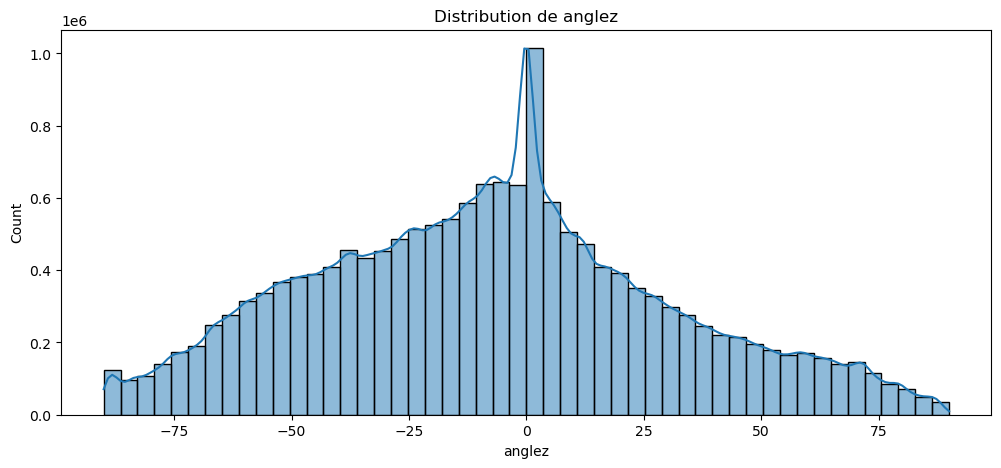

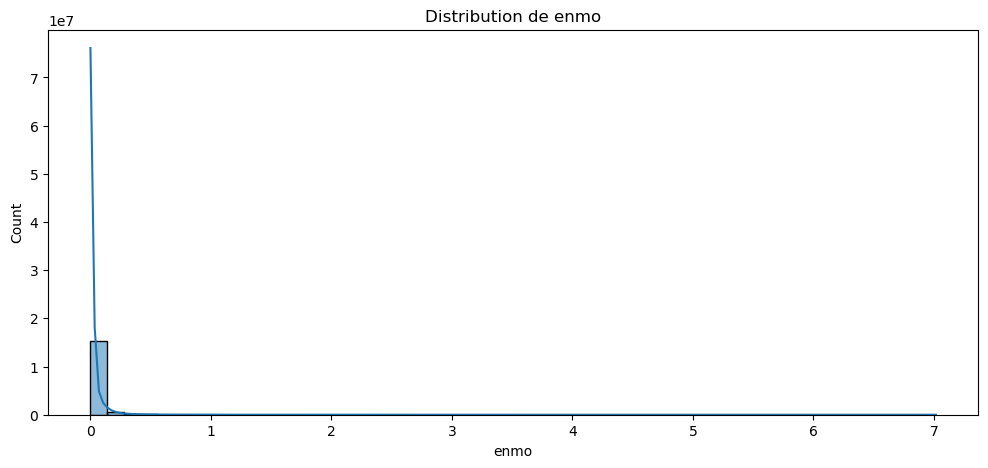

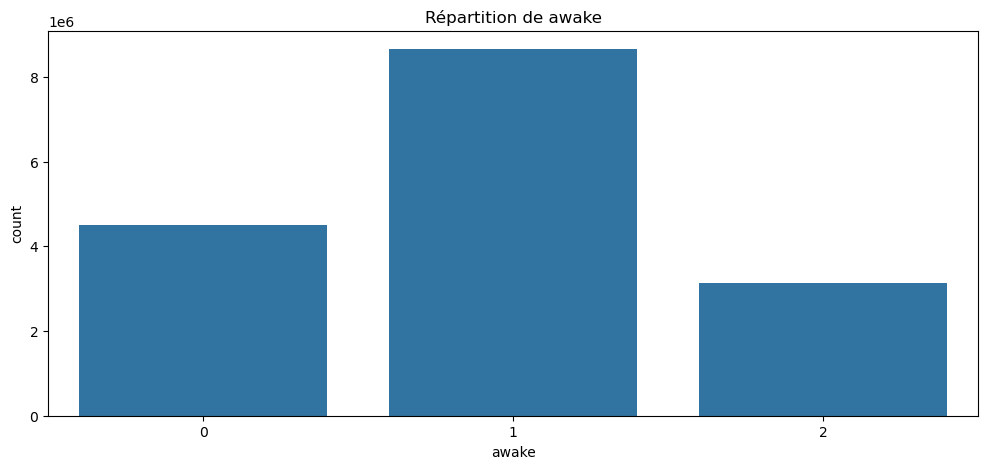

In [39]:
# Exploration des données
plt.figure(figsize=(12, 5))
sns.histplot(df['anglez'], kde=True, bins=50)
plt.title("Distribution de anglez")
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df['enmo'], kde=True, bins=50)
plt.title("Distribution de enmo")
plt.show()

plt.figure(figsize=(12, 5))
sns.countplot(x=df['awake'])
plt.title("Répartition de awake")
plt.show()

In [40]:
# Ajouter les variances de anglez et enmo sur une fenêtre de 5 pas

df['anglez_var'] = df['anglez'].rolling(window=5, min_periods=1).var().fillna(0)
df['enmo_var'] = df['enmo'].rolling(window=5, min_periods=1).var().fillna(0)


# Sélection des features et de la cible
features = ['anglez', 'enmo', 'anglez_var', 'enmo_var']
X = df[features]
y = df['awake']


In [41]:
# lignes contenants des Nan
print(df[df.isna().any(axis=1)])

Empty DataFrame
Columns: [series_id, step, anglez, enmo, awake, hour_sin, hour_cos, anglez_var, enmo_var]
Index: []


In [42]:
# Standardisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Séparation des données en train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modèle Régression Logistique
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
print("Régression Logistique:")
print(classification_report(y_test, y_pred_log))

# Modèle XGBoost
xgb = XGBClassifier(scale_pos_weight=212, eval_metric='logloss')

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost:")
print(classification_report(y_test, y_pred_xgb))


Régression Logistique:


c:\Users\leami\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\leami\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\leami\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.54      0.73      0.62    900864
           1       0.68      0.81      0.74   1731984
           2       0.00      0.00      0.00    625116

    accuracy                           0.63   3257964
   macro avg       0.41      0.51      0.45   3257964
weighted avg       0.51      0.63      0.56   3257964



c:\Users\leami\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:57:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85    900864
           1       0.79      0.91      0.84   1731984
           2       0.76      0.39      0.51    625116

    accuracy                           0.80   3257964
   macro avg       0.79      0.72      0.74   3257964
weighted avg       0.80      0.80      0.78   3257964



In [43]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import numpy as np
import torch

# Vérifier si GPU dispo
use_gpu = torch.cuda.is_available()
print("GPU disponible :", use_gpu)

# Définition des hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 300, 500],  # Nombre d'arbres
    'learning_rate': [0.01, 0.05, 0.1],  # Taux d'apprentissage
    'max_depth': [3, 6, 9],  # Profondeur des arbres
    'subsample': [0.7, 0.8, 1.0],  # Pourcentage de données utilisées par arbre
    'colsample_bytree': [0.7, 0.8, 1.0],  # Pourcentage de colonnes utilisées par arbre
    'gamma': [0, 0.1, 0.3],  # Réduction de sur-apprentissage
}

# Initialisation du modèle avec GPU
xgb = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=5,  # Gestion du déséquilibre
    tree_method="gpu_hist" if use_gpu else "hist",  # Utiliser GPU si dispo
    predictor="gpu_predictor" if use_gpu else "cpu_predictor"
)

# Randomized Search pour trouver les meilleurs paramètres
random_search = RandomizedSearchCV(
    estimator=xgb, param_distributions=param_grid,
    n_iter=5, cv=3, scoring='f1_weighted', verbose=2, n_jobs=4  # Moins de charge CPU
)

# Entraînement sur un sous-ensemble des données pour réduire la RAM utilisée
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, train_size=0.5, stratify=y_train, random_state=42
)
random_search.fit(X_train_sample, y_train_sample)

# Affichage des meilleurs paramètres
print("Meilleurs paramètres :", random_search.best_params_)

# Test sur les données de validation
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred))


GPU disponible : True
Fitting 3 folds for each of 5 candidates, totalling 15 fits


c:\Users\leami\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:04:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\leami\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:04:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor", "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Meilleurs paramètres : {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}


c:\Users\leami\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:05:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.82      0.87      0.85    900864
           1       0.79      0.91      0.84   1731984
           2       0.75      0.35      0.48    625116

    accuracy                           0.79   3257964
   macro avg       0.79      0.71      0.72   3257964
weighted avg       0.79      0.79      0.77   3257964



Meilleurs paramètres : {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}

In [44]:
# Meilleurs paramètres
best_params = {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}
# Initialisation du modèle avec les meilleurs paramètres
xgb = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=5,  # Gestion du
    tree_method="gpu_hist" if use_gpu else "hist",  # Utiliser GPU si dispo
    **best_params
)

# Entraînement sur toutes les données
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))


c:\Users\leami\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:05:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\leami\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:05:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\leami\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:07:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27:

              precision    recall  f1-score   support

           0       0.86      0.87      0.86    900864
           1       0.80      0.91      0.85   1731984
           2       0.78      0.45      0.57    625116

    accuracy                           0.81   3257964
   macro avg       0.81      0.74      0.76   3257964
weighted avg       0.81      0.81      0.80   3257964



In [45]:
# 📌 Sélection des features et target
features = ['anglez', 'enmo', 'hour_sin', 'hour_cos']
target = 'awake'

def create_sequences(df, seq_len=10):
    X_seq, y_seq = [], []
    
    for series in df['series_id'].unique():  
        subset = df[df['series_id'] == series]
        X_values = subset[features].values
        y_values = subset[target].values
        
        for i in range(0, len(X_values) - seq_len, seq_len):  
            X_seq.append(X_values[i:i+seq_len])
            y_seq.append(y_values[i+seq_len-1]) 
        
    return np.array(X_seq), np.array(y_seq)

X, Y = create_sequences(train, seq_len=10)

# 📌 Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Shape X_train :", X_train.shape)
print("Shape y_train :", y_train.shape)


Shape X_train : (1303151, 10, 4)
Shape y_train : (1303151,)


In [46]:
import torch
from torch.utils.data import Dataset, DataLoader

# 📌 Création d'un dataset PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 📌 Convertir les données en datasets PyTorch
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

# 📌 DataLoader pour batch processing
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [47]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)  # Activation Softmax pour classification multi-classes
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Dernière sortie de la séquence
        return self.softmax(out)  # Activation softmax pour prédiction multi-classes

# 📌 Initialisation du modèle
input_size = X_train.shape[2]  # Nombre de features
hidden_size = 64
num_layers = 2
output_size = 3  # 🟢 Maintenant 3 classes (0,1,2)

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")


In [48]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  # 🔥 CrossEntropy pour classification multi-classes
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = "cuda" if torch.cuda.is_available() else "cpu"


In [49]:
from sklearn.metrics import accuracy_score, classification_report

model.eval()
y_pred_list, y_true_list = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        y_pred = torch.argmax(outputs, dim=1).cpu().numpy()  # 🔥 Prendre la classe avec la plus haute proba
        
        y_pred_list.extend(y_pred)
        y_true_list.extend(y_batch.cpu().numpy())

# 📌 Affichage des performances
print("Accuracy:", accuracy_score(y_true_list, y_pred_list))
print(classification_report(y_true_list, y_pred_list))


Accuracy: 0.1830177907105234
              precision    recall  f1-score   support

         0.0       0.04      0.01      0.01     90291
         1.0       0.51      0.00      0.00    172894
         2.0       0.19      0.94      0.32     62603

    accuracy                           0.18    325788
   macro avg       0.25      0.32      0.11    325788
weighted avg       0.32      0.18      0.07    325788

